In [1]:
!pip install spacy==2.2.4

In [2]:
import pandas as pd, spacy, random
from spacy.util import minibatch, compounding
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ArmorDoc_Challenge/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
page_df = pd.read_csv('./data/extracted_data.csv',index_col=0)

In [4]:
page_df.head()

,page_number,image_file_names,image_file_paths,text
0,0,page0.png,/data/png_images/page0.png,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...
1,1,page1.png,/data/png_images/page1.png,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...
2,2,page2.png,/data/png_images/page2.png,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...
3,3,page3.png,/data/png_images/page3.png,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...
4,4,page4.png,/data/png_images/page4.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...


# ML Classifcation Model with Spacy 2
### The Algorithm used for this Model is the "TextCategorizer" (textcat) from the SpaCy API

In [5]:
# this labeled dataset was wrangled in Notebook 4 to train this classification model:
data = pd.read_csv('./data/wrangled_doc_clf_data.csv',index_col=0)

In [6]:
data.head()

,page_number,document_label,text
0,0,first,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...
1,1,first,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...
2,2,second,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...
3,3,second,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...
4,4,second,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...


## Loading Spacy Model

In [7]:
# loading spacy model
nlp = spacy.load("en_core_web_sm")
nlp.pipe_names

['tagger', 'parser', 'ner']

## Adding Text Categorizer Pipeline (for Text Classification)

In [8]:
# Adding the built-in textcat component to the pipeline.
textcat=nlp.create_pipe( "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [9]:
# First Note == 0 == "NEGATIVE", # Second Note ==  1 == "POSITIVE"


# Adding the labels to textcat
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")
textcat.labels

('POSITIVE', 'NEGATIVE')

Formatting Data for TextCat Pipeline

In [10]:
text_list = data['text'].to_list()
label_list = data['document_label'].to_list()
label_list = [1 if i == 'second' else 0 for i in label_list]
DATA = list(zip(text_list, label_list))


In [11]:
# displaying first five rows of formatted dataset:
DATA[:5]

[(' \n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY CONVERSION)\nSTATE OF VA\n\nAugust 29, 2008\n\nPROPERTY ADDRESS FHA Case Number: PF\nLoan\n\nMIN Number:\nNorfolk, VA 23507\nNorfolk (City) COUNTY\n\n1. DEFINITIONS :\n"Borrower" means each person signing at the end of this Note. "Lender" means EverBank Reverse Mortgage LLC and its\nsuccessors and assigns. "Secretary" means the Secretary of Housing and Urban Development or his or her authorized\nrepresentatives.\n\n2. BORROWER\'S PROMISE TO PAY; INTEREST\n\nIn return for amounts to be advanced by Lender up to a maximum principal amount of Four Hundred Seventy Thousand Two\nHundred Fifty and 00/100 Dollars ($470,250.00), to or for the benefit of Borrower under the terms of a Home Equity\nConversion Loan Agreement dated August 29, 2008 ("Loan Agreement"), Borrower promises to pay to the order of Lender a\nprincipal amount equal to the sum of all Loan Advances made under the Loan Agreement with interest. All amounts advanced by\nLender, plus

In [15]:
def load_data(data=data, split=0.8):
    # Shuffle the data
    random.shuffle(data)
    texts, labels = zip(*data)
    # get the categories for each review
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]

    # Splitting the training and evaluation data
    split = int(len(data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

## Creating Train-Validation-Test Split Datasets

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(DATA, test_size=0.1, random_state=42)

# Calling the load_data() function 
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(data=train)
(test_texts, test_cats), (null_texts, null_cats) = load_data(data=test, split=1)


# Processing the final format of training data
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))
dev_data = list(zip(dev_texts,[{'cats': cats} for cats in dev_cats]))
test_data = list(zip(test_texts,[{'cats': cats} for cats in test_cats]))

print("Number of training data samples:", len(train_data))
print("Number of validation data samples:", len(dev_data))
print("Number of test data samples:", len(test_data))
train_data[:5]


## Training Spacy ML Classifier and Evaluating on the Validation Dataset

In [18]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}

In [19]:
#("Number of training iterations", "n", int))
n_iter = 10

# Disabling other components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))

    # Performing training
    for i in range(n_iter):
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)

      # Calling the evaluate() function and printing the scores
        with textcat.model.use_params(optimizer.averages):
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

Training the model...
LOSS 	  P  	  R  	  F  
0.843	0.000	0.000	0.000
0.815	0.000	0.000	0.000
0.700	1.000	0.769	0.870
0.483	1.000	0.923	0.960
0.307	1.000	1.000	1.000
0.291	1.000	1.000	1.000
0.217	1.000	1.000	1.000
0.097	1.000	1.000	1.000
0.052	1.000	1.000	1.000
0.018	1.000	1.000	1.000


## Evaluating the Model on the Holdout Test Dataset

In [20]:
pred_list = [] 
true_list = []
for test_tuple in test_data:
  doc = nlp(test_tuple[0])
  pred = doc.cats
  pred = max(pred, key=pred.get)
  true_val = test_tuple[1]['cats']
  true_val = max(true_val, key=true_val.get)
  pred_list.append(pred)
  true_list.append(true_val)

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00        10
    POSITIVE       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



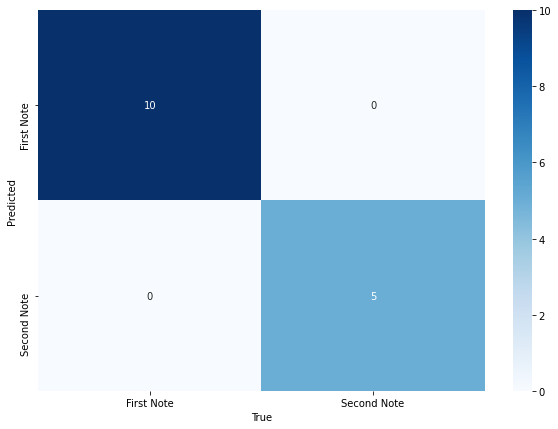

In [21]:
print(classification_report(true_list,pred_list))
array = confusion_matrix(true_list,pred_list)

df_cm = pd.DataFrame(array, index = ['First Note', 'Second Note'],
                  columns =  ['First Note', 'Second Note'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

### Saving the Spacy ML Classification Model

In [23]:
folder_path = './data/spacy_ml_classification_model.pth'
nlp.to_disk(folder_path)